In [ ]:
!pip install kapre==0.1.7
!pip install gast>=0.3.2
!pip install tensorflow==1.15.0
!pip install keras==2.3.1
!ypip uninstall h5py
!pip install h5py==2.10.0

In [1]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = '/content/drive/MyDrive/Smoke-detecttion-image-processing/dataset'
train_image_dir = os.path.join(data_dir, 'D:/dataset/smoke/data_unet/train')
test_image_dir = os.path.join(data_dir, 'D:/dataset/smoke/data_unet/test')
import gc; gc.enable() # memory is tight
from skimage.morphology import label

c:\Users\phuong\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\phuong\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\phuong\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
BATCH_SIZE = 4
EDGE_CROP = 2
NB_EPOCHS = 15
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 50
AUGMENT_BRIGHTNESS = False

In [7]:
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'images')
    images = glob.glob(os.path.join(img_path,'*.*'))
    return [os.path.basename(image) for image in images]

In [ ]:
print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())


In [10]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final

In [ ]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = img_file_list
    out_rgb = []
    out_mask = []
    img_path = os.path.join(train_image_dir,'images')
    mask_path = os.path.join(train_image_dir,'masks')
    while True:
        np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img = imread(os.path.join(img_path,c_img_id))
            c_img = cv2_brightness_augment(c_img)
            c_mask = imread(os.path.join(mask_path,c_img_id))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [ ]:
train_gen = make_image_gen()
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg, cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

In [ ]:
valid_x, valid_y = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
print(valid_x.shape, valid_y.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 256, 256, 3) float32 0.0 0.7372549
y (4, 256, 256, 1) float32 0.0 1.0


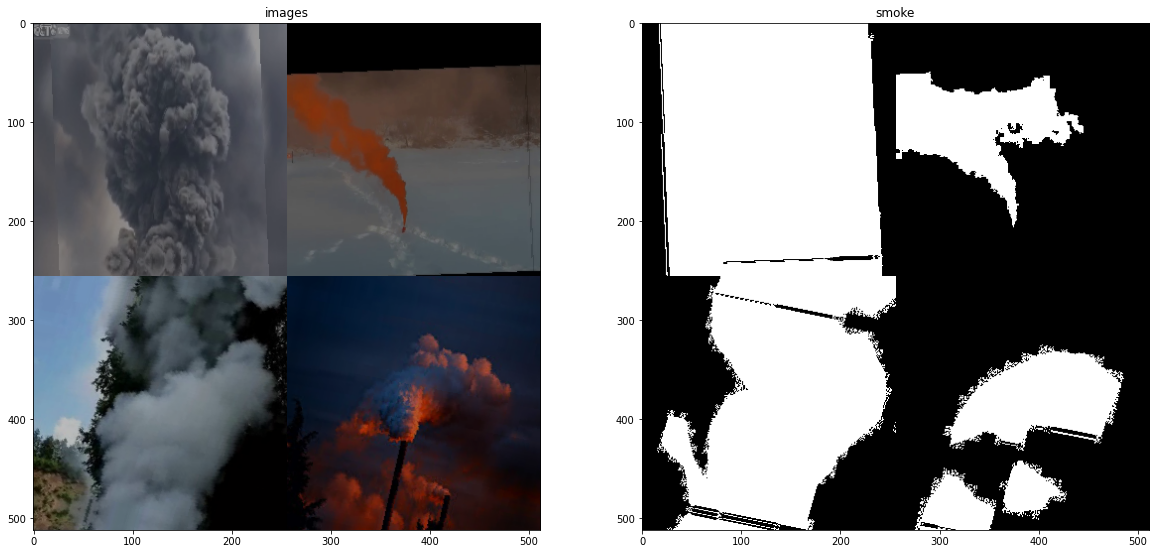

In [ ]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
ax2.set_title('smoke')
fig.savefig('augmentations.png')

In [ ]:
gc.collect()

75

In [ ]:
from keras import models, layers

def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
p5 = layers.MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same') (p5)
c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same') (c6)
p6 = layers.MaxPooling2D(pool_size=(2, 2)) (c6)

c7 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (p6)
c7 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (c7)
p7 = layers.MaxPooling2D(pool_size=(2, 2)) (c7)

c8 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same') (p7)
c8 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(1024, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c7])
c9 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same') (c9)

u10 = upsample(512, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = layers.concatenate([u10, c6])
c10 = layers.Conv2D(512, (3, 3), activation='relu', padding='same') (u10)
c10 = layers.Conv2D(512, (3, 3), activation='relu', padding='same') (c10)

u11 = upsample(256, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = layers.concatenate([u11, c5])
c11 = layers.Conv2D(256, (3, 3), activation='relu', padding='same') (u11)
c11 = layers.Conv2D(256, (3, 3), activation='relu', padding='same') (c11)

u12 = upsample(128, (2, 2), strides=(2, 2), padding='same') (c11)
u12 = layers.concatenate([u12, c4], axis=3)
c12 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (u12)
c12 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c12)

u13 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c12)
u13 = layers.concatenate([u13, c3], axis=3)
c13 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u13)
c13 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c13)

u14 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c13)
u14 = layers.concatenate([u14, c2], axis=3)
c14 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u14)
c14 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c14)

u15 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c14)
u15 = layers.concatenate([u15, c1], axis=3)
c15 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u15)
c15 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c15)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c15)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()














__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         batch_normalization_1[0][0]      
________________________________________________________________________________________________

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    print(y_true,y_pred)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensor("zero_padding2d_1_target:0", shape=(?, ?, ?, ?), dtype=float32) Tensor("zero_padding2d_1/Pad:0", shape=(?, 256, 256, 1), dtype=float32)
Tensor("zero_padding2d_1_target:0", shape=(?, ?, ?, ?), dtype=float32) Tensor("zero_padding2d_1/Pad:0", shape=(?, 256, 256, 1), dtype=float32)


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
step_count = min(MAX_TRAIN_STEPS, len(TRAIN_IMGS)//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen())
val_gen = make_image_gen(TEST_IMGS, len(TEST_IMGS)//BATCH_SIZE)
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=val_gen,
                             validation_steps=len(TEST_IMGS)//BATCH_SIZE,
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]



Epoch 1/15
49/50 [============================>.] - ETA: 1s - loss: -0.3064 - dice_coef: 0.3074 - binary_accuracy: 0.2560 - true_positive_rate: 0.9786
Epoch 00001: val_dice_coef improved from -inf to 0.33972, saving model to seg_model_weights.best.hdf5
50/50 [==============================] - 669s 13s/step - loss: -0.3045 - dice_coef: 0.3056 - binary_accuracy: 0.2538 - true_positive_rate: 0.9788 - val_loss: -0.3371 - val_dice_coef: 0.3397 - val_binary_accuracy: 0.2515 - val_true_positive_rate: 0.9890
Epoch 2/15
49/50 [============================>.] - ETA: 0s - loss: -0.3532 - dice_coef: 0.3573 - binary_accuracy: 0.2659 - true_positive_rate: 0.9816
Epoch 00002: val_dice_coef improved from 0.33972 to 0.34107, saving model to seg_model_weights.best.hdf5
50/50 [==============================] - 646s 13s/step - loss: -0.3577 - dice_coef: 0.3617 - binary_accuracy: 0.2683 - true_positive_rate: 0.9815 - val_loss: -0.3395 - val_dice_coef: 0.3411 - val_binary_accuracy: 0.2513 - val_true_posit

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model_smoke.h5')

In [ ]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

In [ ]:
test_paths = os.listdir('/content/drive/MyDrive/Smoke-detecttion-image-processing/dataset/test/images')
print(len(test_paths), 'test images found')

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join('/content/drive/MyDrive/Smoke-detecttion-image-processing/dataset/test/images', c_img_name)
    c_img = imread(c_path)
    c_img = cv2.resize(c_img,(256,256))
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = (first_img[0][:,:,0]*0.7 + 0.5*first_seg[0, :, :, 0])
    result = np.array(np.clip(first_img[0]*255.,0,255),dtype=np.int32)
    ax1.imshow(result)
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1, cmap='gray')
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

In [ ]:
from moviepy.editor import VideoFileClip
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_shape = image.shape[:2]
#     print(image_shape)
    image = cv2.resize(image,(256,256))
    first_img = np.expand_dims(image, 0)/255.0
#     result = image_pipeline(image)
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = first_img[0][:,:,0]*0.7 + 0.3*first_seg[0, :, :, 0]
    result = np.array(np.clip(first_img[0]*255,0,255),dtype=np.float)
#     print(image_shape[:2],result.shape,type(result[0][0][0]))
    result = cv2.resize(result,image_shape[::-1])
#     result = result[...,::-1]
    
    return result

In [ ]:
filename='/content/drive/MyDrive/Smoke-detecttion-image-processing/OrangeSmoke.mp4'
clip = VideoFileClip(filename)
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(filename.split('.')[0]+'_detection.mp4', audio=False)

In [ ]:
def pred_gen(src):
  vicap = cv2.VideoCapture(src)
  ret,image = vicap.read()
  while ret:
    ret, image = vicap.read()
    if(ret==True):
      image = cv2.resize(image, (256, 256))
      yield image
def make_video():
  images = [img for img in pred_gen("/content/drive/MyDrive/Smoke-detecttion-image-processing/OrangeSmoke.mp4")]
  frame = images[0]
  height, width, layers = frame.shape  
  video = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (width,height))
  i=0
  for image in images:
    i+=1
    first_img = np.expand_dims(image, 0)/255.0
    first_seg = seg_model.predict(first_img)
    first_img[0][:,:,0] = (first_img[0][:,:,0]*0.7 + 0.5*first_seg[0, :, :, 0])
    result = np.array(np.clip(first_img[0]*255.,0,255),dtype=np.uint8)
    video.write(result)
    print(i)
    break
  cv2.destroyAllWindows() 
  video.release()
make_video()

In [ ]:
def pred_gen(src):
  vicap = cv2.VideoCapture(src)
  ret,image = vicap.read()
  while ret:
    ret, image = vicap.read()
    if(ret==True):
      image = cv2.resize(image, (256, 256))
      yield image
images = [img for img in pred_gen("/content/drive/MyDrive/Smoke-detecttion-image-processing/SmokeBlue.mp4")]

import cv2
from PIL import Image
frame = images[0]
# height, width, layers = frame.shape
# fig, m_axs = plt.subplots(1, 2, figsize = (10, 40))
# video = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (width,height))
img = Image.fromarray(frame, 'RGB')
fig, (ax1, ax2) = plt.subplots(1, 2)
first_img = np.expand_dims(img, 0)/255.0
first_seg = seg_model.predict(first_img)
ax1.imshow(img)
ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1, cmap='gray')

In [ ]:
# from prettytable import PrettyTable

# def count_parameters(model):
#     table = PrettyTable(["Modules", "Parameters"])
#     total_params = 0
#     for name, parameter in model.named_parameters():
#         if parameter.requires_grad:
#             param = parameter.numel()
#             table.add_row([name, param])
#             total_params+=param
#     print(table)
#     return f"{total_params:,}"
    
# count_parameters(seg_model)